## 1. Importation Libraries

In [4]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score


## 2. Data Cleaning

In [13]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

# Cleaning
df = df.drop(columns=['Ref#'])
df['Raw Material'] = df['Raw Material'].str.title()

# Substitute every NaN with 'NA'
df = df.fillna('NA')

In [14]:
all_parts = set()
df["Other assembled RM/Rivet/part"].dropna().str.split(r" \+ ").apply(all_parts.update)

# Creating new columns for each extracted part
for part in all_parts:
    df[part] = df["Other assembled RM/Rivet/part"].apply(lambda x: part in x if pd.notna(x) else False)

df = df.drop(columns=['NA', 'Other assembled RM/Rivet/part'])
df

,Production,Annual target quantity,Raw Material,Raw Material Designation,Surface Treatment,Heat treatment,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Other RM/Rivet/part cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil
0,A,1500000.0,Copper,Cu-ETP-R240,NA,NA,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.000103,0.051500,False,True
1,A,1000000.0,Copper,Cu-ETP-R240,Sn5,NA,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.000103,0.058863,False,True
2,A,1500000.0,Copper,Cu-ETP-R240,Sn5,NA,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.000103,0.089343,False,True
3,A,1500000.0,Copper,Cu-ETP-R240,Sn5,NA,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.000000,0.057637,False,False
4,A,1500000.0,Steel,DC03,Sn5,NA,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.000000,0.018332,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,E,44538.0,Copper,Cu-ETP-R240,NA,NA,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,0.000000,1.538638,False,False
155,E,38260.0,Steel,SUS304 1/2H,NA,NA,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.000000,0.353694,False,False
156,E,13478.0,Steel,SPCC-2B,ZnCr3+,NA,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.000000,0.648388,False,False
157,E,38260.0,Steel,SPCC-2B,ZnCr3+,NA,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.000000,0.097968,False,False


## 3. Analyse Graphique

### 3.1 Matrix de Correlation Lineaire

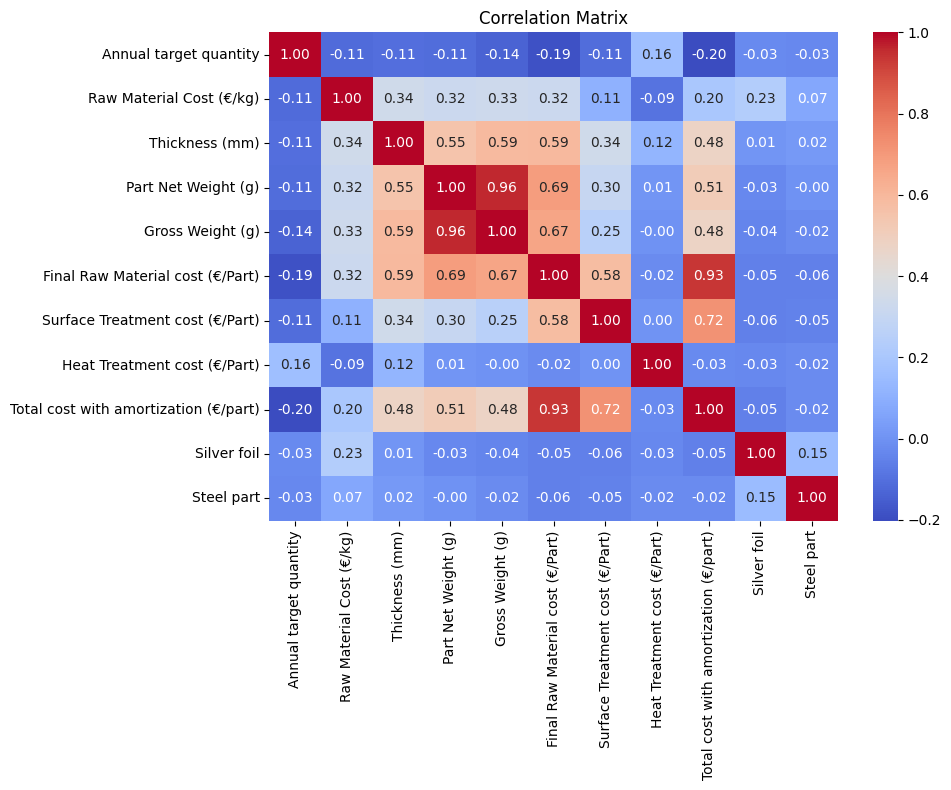

In [15]:
# Select the relevant columns
columns_of_interest = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
    'Part Net Weight (g)', 'Gross Weight (g)', 'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)', 
    'Total cost with amortization (€/part)', 'Silver foil', 'Steel part'
]

# Calculate the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### 3.2 Parallel Coordinates 

In [16]:
fig = px.parallel_coordinates(
    df[columns_of_interest], 
    dimensions=columns_of_interest,
    color=df['Steel part'],  # Color by Steel part
    color_continuous_scale=['blue', 'red'],
    title="Interactive Parallel Coordinates Plot"
)

# Update layout for better visualization
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600
)

# Show the plot
fig.show()

### 3.3 Scatter Plot

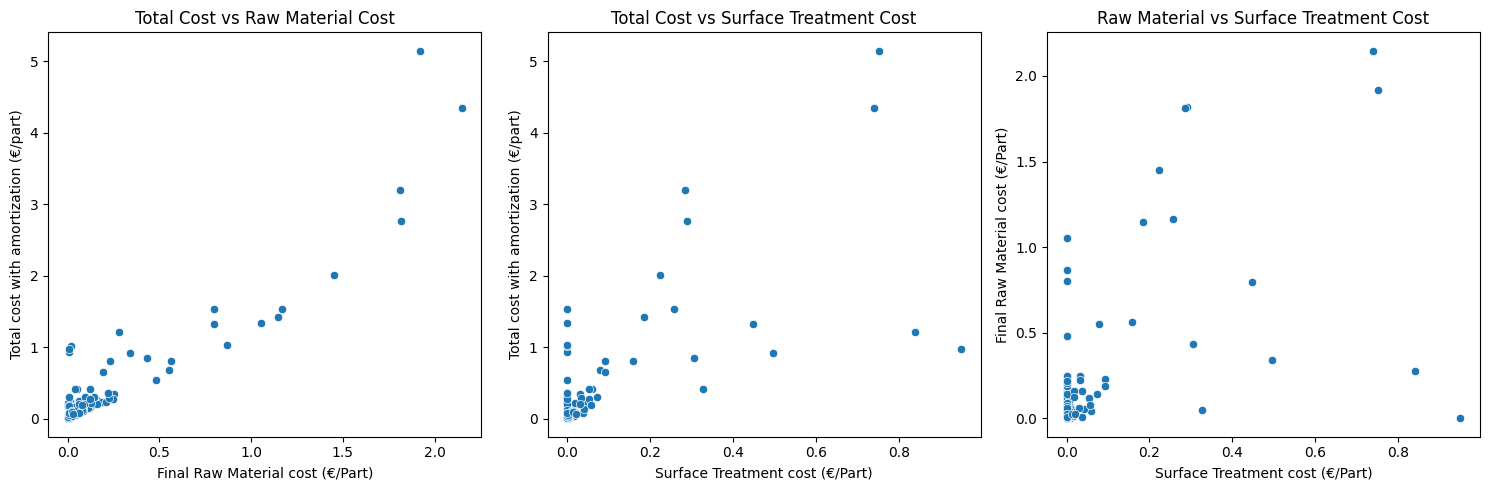

In [17]:
# Create figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define the variables
cost_vars = [
    "Total cost with amortization (€/part)",
    "Final Raw Material cost (€/Part)",
    "Surface Treatment cost (€/Part)"
]

# Create scatter plots
# Plot 1: Total Cost vs Raw Material Cost
sns.scatterplot(
    data=df,
    x=cost_vars[1],
    y=cost_vars[0],
    ax=axes[0]
)
axes[0].set_title('Total Cost vs Raw Material Cost')

# Plot 2: Total Cost vs Surface Treatment Cost
sns.scatterplot(
    data=df,
    x=cost_vars[2],
    y=cost_vars[0],
    ax=axes[1]
)
axes[1].set_title('Total Cost vs Surface Treatment Cost')

# Plot 3: Raw Material Cost vs Surface Treatment Cost
sns.scatterplot(
    data=df,
    x=cost_vars[2],
    y=cost_vars[1],
    ax=axes[2]
)
axes[2].set_title('Raw Material vs Surface Treatment Cost')

# Adjust layout
plt.tight_layout()
plt.show()

## 4. Data Mining

In [173]:
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Prepare your data
X = df.drop("Total cost with amortization (€/part)", axis=1)
y = df["Total cost with amortization (€/part)"]

# Initialize TPOT
tpot = TPOTRegressor(
    generations=10,
    population_size=50,
    cv=5,
    verbosity=2,
    random_state=42,
    n_jobs=-1,  # Use all available cores
    max_time_mins=5
)

# Fit TPOT
tpot.fit(X, y)

# Get cross-validation scores
cv_scores = cross_val_score(
    tpot.fitted_pipeline_,
    X,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Print results
print("\nBest pipeline:", tpot.fitted_pipeline_)
print("\nCross-validation RMSE scores:", -cv_scores)
print("Average RMSE:", -cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# Export the pipeline to a Python file
tpot.export('tpot_pipeline.py')

# Feature importance (if the best model supports it)
if hasattr(tpot.fitted_pipeline_[-1], 'feature_importances_'):
    importances = tpot.fitted_pipeline_[-1].feature_importances_
    features = X.columns
    for feat, imp in zip(features, importances):
        print(f"{feat}: {imp}")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


ValueError: could not convert string to float: 'A'